In [1]:
import rubrix as rb
import modAL
import sklearn
import pandas as pd

/Users/maxine/Library/Python/3.9/lib/python/site-packages/jose/backends/cryptography_backend.py:18: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes, int_to_bytes


In [ ]:
# >>> import fasttext.util
# >>> fasttext.util.download_model('en', if_exists='ignore')  # English
# >>> ft = fasttext.load_model('cc.en.300.bin')

In [6]:
# If you are using the default installation you can skip this line
# train_df = pd.read_csv("https://raw.githubusercontent.com/recognai/rubrix/master/docs/tutorials/data/yt_comments_train.csv")
# test_df = pd.read_csv("https://raw.githubusercontent.com/recognai/rubrix/master/docs/tutorials/data/yt_comments_test.csv")

train_df = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label'])
test_df = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label'])

In [7]:
train_df.head()

,text,tokenized_text,se_label
0,Los activos en divisas en poder del Banco Cent...,Los activos en divisas en poder de el Banco Ce...,expl:pass
1,Las reservas en oro se valoran en base a 300 d...,Las reservas en oro se valoran en base a 300 d...,expl:pass
2,"Según Pujol, no puede ser que se tarde ocho me...","Según Pujol , no puede ser que se tarde ocho m...",expl:impers
3,"Sin embargo, los abogados de la empresa indica...","Sin embargo , los abogados de la empresa indic...",expl:pass
4,El Departamento de Justicia dijo respecto a la...,El Departamento de Justicia dijo respecto a la...,expl:pass


In [8]:
test_df.head()

,text,tokenized_text,se_label
0,"Además, estas dos naciones tienen una larga hi...","Además , estas dos naciones tienen una larga h...",expl:pv
1,"Aviones aterrizando o despegando, cristales ro...","Aviones aterrizando o despegando , cristales r...",expl:pv
2,Lo que ocurre con ese caballero es que se trat...,Lo que ocurre con ese caballero es que se trat...,expl:impers
3,Yo tardé mucho tiempo en enterarme de que no h...,Yo tardé mucho tiempo en enterar me de que no ...,expl:impers
4,- Acabará aceptándose ese factor como un nuevo...,- Acabará aceptando se ese factor como un nuev...,expl:pass


In [9]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()


In [10]:
from modAL.models import ActiveLearner
learner = ActiveLearner(estimator=classifier,)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,5))

X_train = vectorizer.fit_transform(train_df.text)
X_test = vectorizer.transform(test_df.text) # not CONTENT as specified in docs

In [29]:
# Number of instances we want to annotate per iteration
n_instances = 10

# Accuracies after each iteration to keep track of our improvement
accuracies = []

reejecutar desde aqui


In [36]:
from sklearn.exceptions import NotFittedError

# query examples from our training pool with the most uncertain prediction
query_idx, query_inst = learner.query(X_train, n_instances=n_instances)

# get predictions for the queried examples
try:
    probabilities = learner.predict_proba(X_train[query_idx])
# For the very first query we do not have any predictions
except NotFittedError:
    probabilities = [[0.2, 0.2,0.2, 0.2, 0.2]]*n_instances

In [37]:
import rubrix as rb

# Build the Rubrix records
records = [
    rb.TextClassificationRecord(
        id=idx,
        inputs=train_df.text.iloc[idx], # not CONTENT as in docs
        # prediction=list(zip(["HAM", "SPAM"], probs)),
        prediction=list(zip(['expl:pass', 'obj', 'expl:impers', 'iobj', 'expl:pv'], probs)),
        prediction_agent="MultinomialNB",
    )
    for idx, probs in zip(query_idx, probabilities)
]

# Log the records
rb.log(records, name="active_learning_tutorial")

  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/active_learning_tutorial


BulkResponse(dataset='active_learning_tutorial', processed=10, failed=0)

In [ ]:
## Load it back into pandas

In [33]:
# Load the annotated records into a pandas DataFrame
records_df = rb.load("active_learning_tutorial", ids=query_idx.tolist())

# check if all examples were annotated
if any(records_df.annotation.isna()):
    raise UserWarning("Please annotate first all your samples before teaching the model")

# train the classifier with the newly annotated examples
y_train = records_df.annotation.map(lambda x: int(x == "SPAM"))
learner.teach(X=X_train[query_idx], y=y_train.to_list())


# Keep track of our improvement
accuracies.append(learner.score(X=X_test, y=test_df.se_label)) # not CLASS as in docs

In [34]:
print(accuracies)

[0.0]


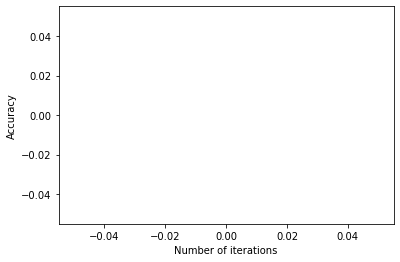

In [35]:
import matplotlib.pyplot as plt

# Plot the accuracy versus the iteration number
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy");